In [1]:
from diffusion import *
import unets

from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader
from torchvision import datasets
import copy
import time
import os
import matplotlib.pyplot as plt

In [2]:
diffusion_steps = 1000
sampling_steps = 250
batch_size = 128
image_size = 28
num_channels = 1
lr = 0.0001
epochs = 201
ema_w = 0.9995

In [3]:
model = unets.__dict__["UNetSmall"](
    image_size=image_size,
    in_channels=1,
    out_channels=1,
    num_classes=None,
).cuda()

diffusion = GuassianDiffusion(diffusion_steps, "cuda:0")
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [4]:
train_set = datasets.MNIST(
    root="./", train=True, download=True, transform=ToTensor())
train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        sampler=None,
        num_workers=4,
        pin_memory=True,
)

In [5]:
ema_dict = copy.deepcopy(model.state_dict())
logger = loss_logger(len(train_loader) * epochs)

In [6]:
def save_samples(model, 
                 diffusion,
                 epoch,
                 fname,
                 n_samples=8,
                 figsize=(6, 8),
                 figshape=(8, 6),
                 image_size=image_size,
                 num_channels=num_channels,
                 sampling_steps=sampling_steps,
                 check_points=5):
    assert figshape[0] == n_samples
    assert figshape[1] == check_points+1
    assert sampling_steps%check_points == 0
    
    z = torch.randn(n_samples, num_channels, image_size, image_size).cuda()
    
    with torch.no_grad():
        imgs = diffusion.sample_from_reverse_process(model, z, sampling_steps, check_points, {"y": None}, False)
    
    fig, axes = plt.subplots(figshape[0], figshape[1], figsize=figsize)
    fig.suptitle("Epoch {}".format(epoch))
    for i in range(figshape[0]):
        for j in range(figshape[1]):
            axes[i][j].set_axis_off()
            axes[i][j].imshow(imgs[j][i].view((image_size, image_size)).detach().cpu())
    plt.savefig(fname=fname)

Epochs: 1/201  Loss (ema): 0.8279768237233348  Time elapsed: 1.45 minutes
Epochs: 2/201  Loss (ema): 0.6658815265514525  Time elapsed: 3.02 minutes
Epochs: 3/201  Loss (ema): 0.5367484944269559  Time elapsed: 4.46 minutes
Epochs: 4/201  Loss (ema): 0.43418628312311125  Time elapsed: 5.91 minutes
Epochs: 5/201  Loss (ema): 0.35277895952504074  Time elapsed: 7.35 minutes
Epochs: 6/201  Loss (ema): 0.28824174886635556  Time elapsed: 8.80 minutes
Epochs: 7/201  Loss (ema): 0.23704950951151188  Time elapsed: 10.25 minutes
Epochs: 8/201  Loss (ema): 0.1963691342730861  Time elapsed: 11.69 minutes
Epochs: 9/201  Loss (ema): 0.16403477063204716  Time elapsed: 13.14 minutes
Epochs: 10/201  Loss (ema): 0.1384028402785834  Time elapsed: 14.58 minutes
Epochs: 11/201  Loss (ema): 0.11805085203044444  Time elapsed: 16.03 minutes
Epochs: 12/201  Loss (ema): 0.10185555463595207  Time elapsed: 17.48 minutes
Epochs: 13/201  Loss (ema): 0.08900564401224313  Time elapsed: 18.93 minutes
Epochs: 14/201  Los

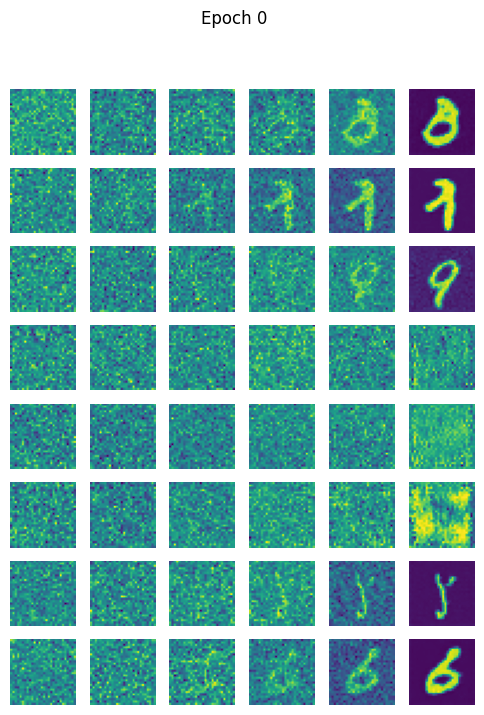

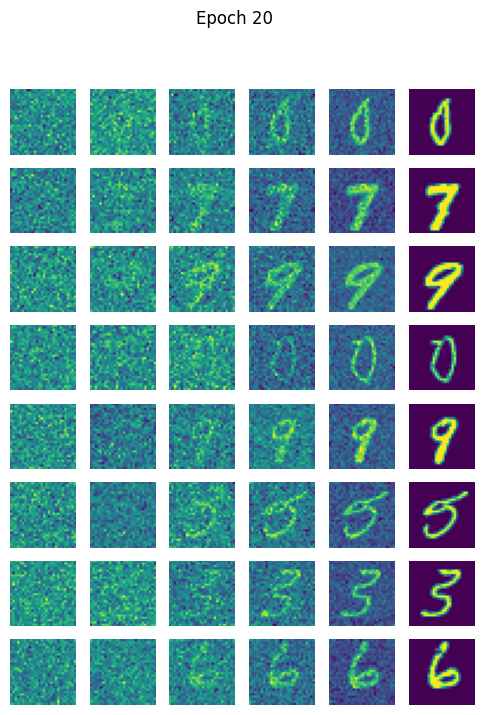

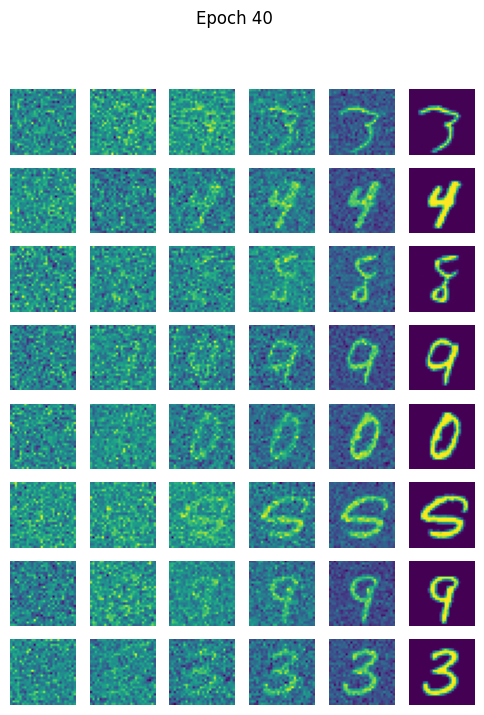

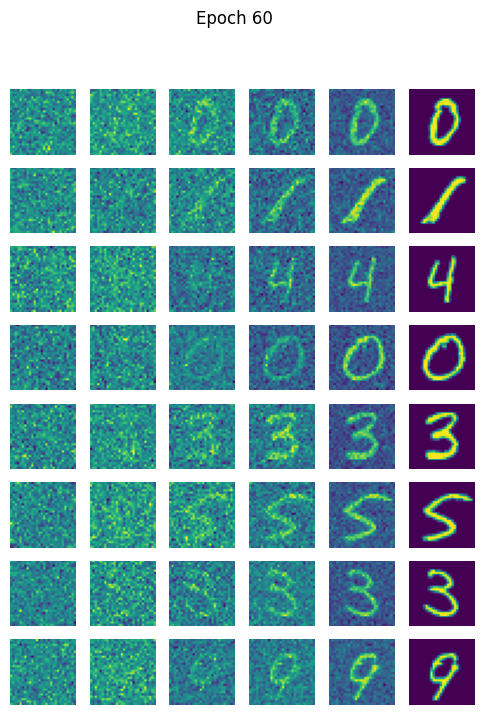

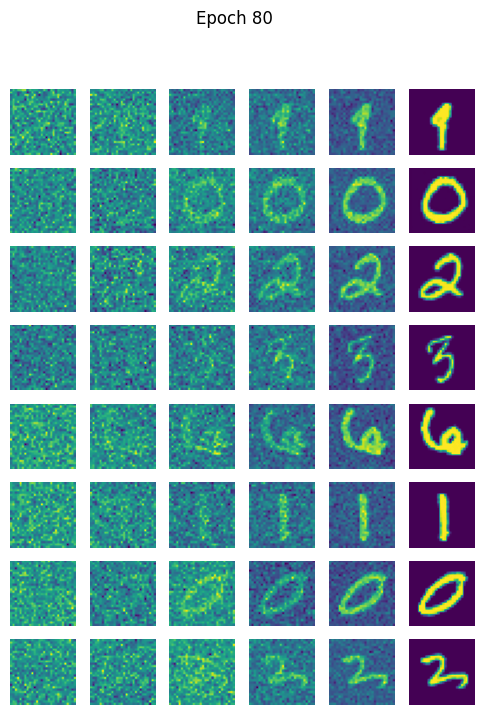

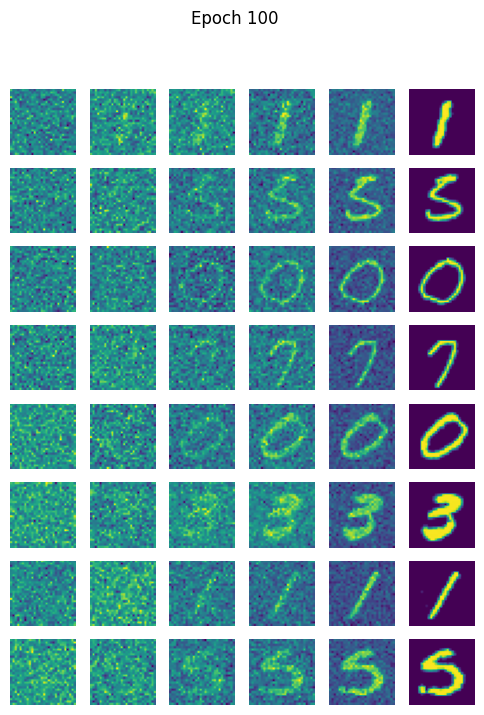

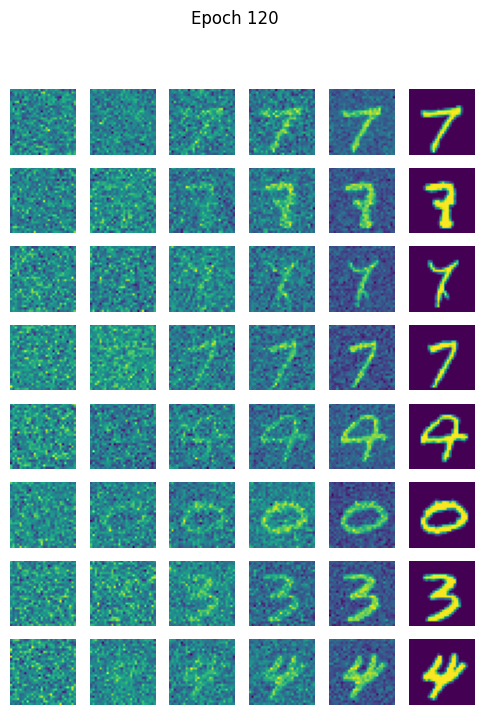

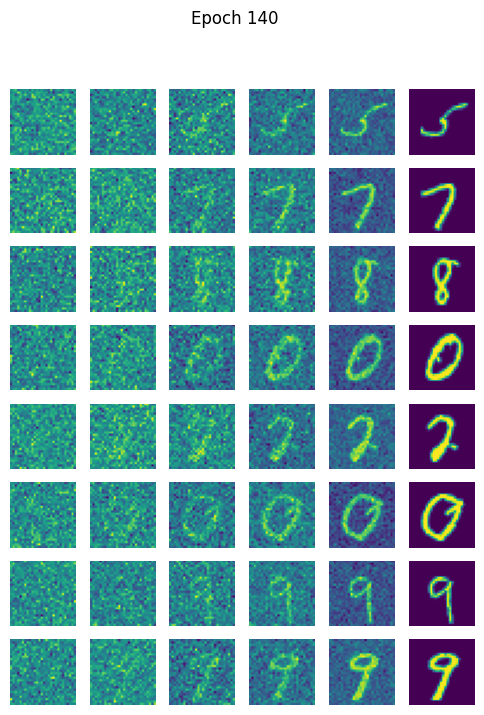

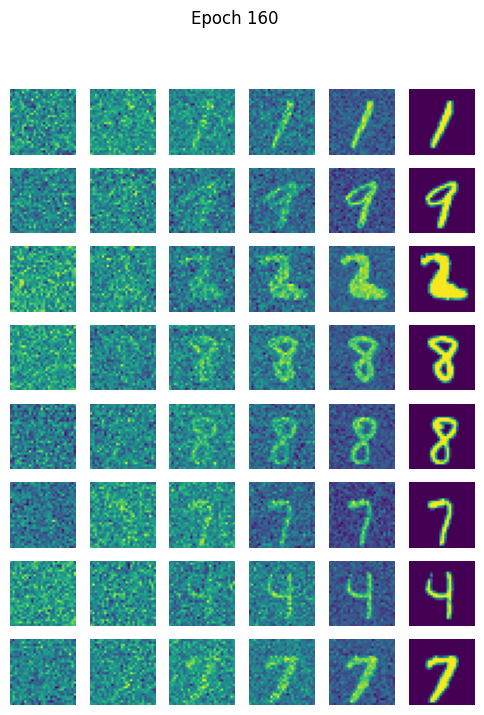

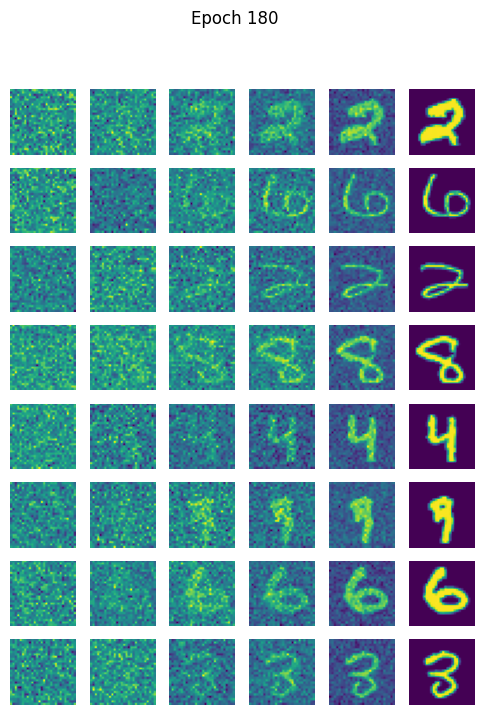

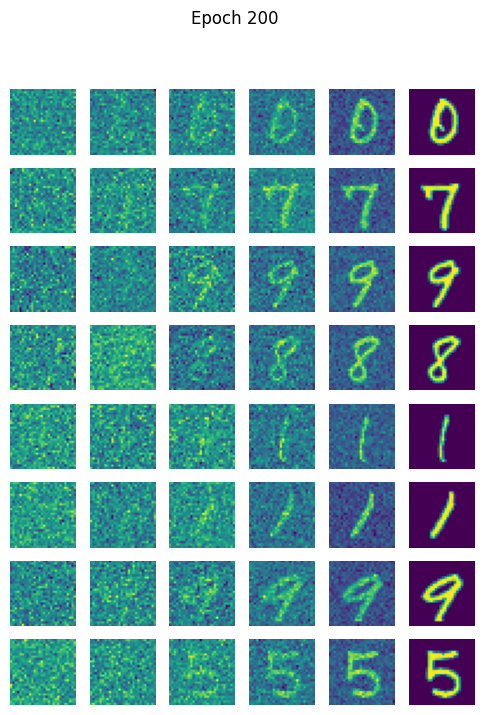

In [7]:
t0 = time.time()
for epoch in range(epochs):
    train_one_epoch(model, train_loader, diffusion, optimizer, logger, None,
                    ema_dict, ema_w)
    print("Epochs: {}/{}  Loss (ema): {}  Time elapsed: {:.2f} minutes"
          .format(epoch+1, epochs, logger.ema_loss, (time.time()-t0)/60))
    if not epoch % 20:
        save_samples(model, diffusion, epoch, "./Diffusion_samples/Epoch_{}.png".format(epoch))
        torch.save(
            model.state_dict(),
            f"models/Diffusion_epoch_{epoch}.pth"
        )
        torch.save(
            ema_dict,
            f"models/EMA_epoch_{epoch}.pth"
        )

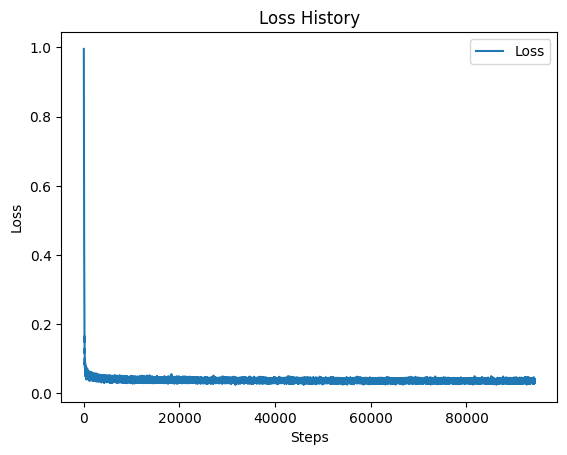

In [10]:
plt.plot(logger.loss, label='Loss')
plt.title("Loss History")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig(fname="./Diffusion_Loss.png")
plt.show()